# A Brief Analysis of A Spotify User's "Liked Songs" Playlist

This notebook is meant to give an example of how Spotify users can download and inspect their data.

In this instance, the configured user from the YAML file is logged in via Selenium to authenticate the OAuth 2.0 interaction. Then, the user's liked songs are donwloaded, and a variety of analyses ensue. Other API calls are made to inspect various API offerings along the way as well.

Finally, some cleaned and aggregated data are saved into flat files for use in other visualization platforms. Please see the README for a full dictionary.

In this notebook, outputs' artist and track names are hashed for privacy purposes. These lines can easily be commented out when running in a non-example context. IDs are left as-is if readers really want to go to the proper lengths to explore the example user's liked songs 🙂

## Table of Contents

- [Local Library Setup](#locallibrarysetup)
    - [Package Imports](#packageimports)
    - [Display Preferences](#displaypreferences)
    - [Functions](#functions)
        - [General Data Cleansing](#generaldatacleansing)
        - [Spotify-Specific Functions](#spotifyspecificfunctions)
- [Script Start](#scriptstart)
    - [Authentication](#authentication)
        - [Selenium-Based OAuth 2.0 Authentication](#selenium)
        - [Bearer Token Retrieval](#bearertokenretrieval)
    - [Obtain "Liked" Track Details](#obtainlikedtrackdetails)
    - [Timeline of When Tracked Are Liked](#timeline)
    - [Additional API Exploration](#additionalapiexploration)
        - [Long Term Top Tracks](#longtermtoptracks)
        - [Followed Artists](#followedartists)

## Local Library Set Up <a name="locallibrarysetup"></a>

This section imports packages, sets display preferences, and defines functions.

### Package Imports <a name="packageimports"></a>

`json`, `requests`, `jmespath`, and `base64` handle making API requests and analyzing the responses.

`yaml` is used strictly for configuration files. See the README for usage instructions.

The `ipywdigets` package is used to dislpay a live progress bar for heavier API requests.

`numpy`, `matplotlib.pyplot`, and `pandas` are crucial to quickly analyize, transform, and visualize data.

`selenium` and `webdriver_manager.chrome` are needed to input the Spotify user credentials into the app to authenticate the interaction via Oauth 2.0.

Lastly, the `time` package allows for a brief seconds-long pause to ensure web interactions complete successfully before processing continues.

In [25]:
import json
import requests
import jmespath
import base64
import yaml

import ipywidgets as widgets
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager

import time

### Display Preferences <a name="displaypreferences"></a>

The number of columns was not restricted to inspect all of the data's fields in this application. Additionally, a large amount of rows to display helped achieve this same goal.

In [26]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 600)

### Functions <a name="functions"></a>

This section defines all of the custom functions needed throughout the script.

#### General Data Cleansing <a name="generaldatacleansing"></a>

These functions are not unique to Spotify purposes.

In [27]:
# Helper function
# A field of JSON from a row of data is converted to its own dataframe
# In addtion, the unique id columns from its source are appended on as the first columns.
# Args:
# pd_series is a row of data from a pandas DataFrame.
# id_names is either a string of the id column's name, or a list of strings of the id columns' names.
# json_col_to_parse is the name of the JSON column to convert to a DataFrame.
def assign_id_and_parse(pd_series, id_names, json_col_to_parse):
    # Convert to a list if not one already
    id_names = id_names if isinstance(id_names, list) else [id_names]
    
    # Convert the nested lists of dictionaries to a DataFrame
    retVal = pd.DataFrame(pd_series[json_col_to_parse])
    
    # Insert the current ID as the first column, going backwards through the list.
    for curr_id_name in id_names[::-1]:
        retVal.insert(0, curr_id_name, pd_series[curr_id_name])
    
    return retVal

# This function takes a DataFrame and parses a column, for which each row is JSON.
# Each JSON value is converted to its own DataFrame.
# In addtion, for each new DataFrame, the unique id columns from its source are appended on as the first columns.
# Finally, the resultant DataFrames are unioned together and returned.
# Args:
# df is the DataFrame to parse
# id_col_names is either a string of the id column's name, or a list of strings of the id columns' names.
# json_col_name is the name of the JSON column to convert to a DataFrame.
def convert_json_col_to_dataframe_with_key(df, id_col_names, json_col_name):
    retVal_list = list()
    
    # Go through all rows, parse the JSON, assign the unique ID(s). Union the results.
    for i, df_row in df.iterrows():
        retVal_list.append(assign_id_and_parse(df_row, id_col_names, json_col_name))
    
    return pd.concat(retVal_list).reset_index(drop = True)

#### Spotify-Specifc Functions <a name="spotifyspecificfunctions"></a>

These fuctions are specific to interacting with the Spotify API.

In [28]:
# Convenience function to write a pandas DataFrame into the data_out folder of the project setup.
# Args:
# pd_df is the pandas DataFrame
# filename is the name for the new file to write
def spotify_write_df_to_data_out_csv(pd_df, filename):
    pd_df.to_csv(f'data_out/{filename}.csv', index = False)

In [29]:
# Convenience function to call the Spotify API
# Args:
# access_token: the token retrieved through Oauth 2.0
# endpoint: the Spotify endpoint to hit
# content_type: a string of the value to pass to the API Content-Type header
# query: a dictionary of key value pairs to send via the API. Defaulted to an empty dictionary if not needed.
# max_parse_level: passed to pd.normalize and controls how JSON is flattened. The default, 0, ensures max flattening.
# base_obj: a string to pass if the returned JSON is wrapped in a tag. Used to filter out the tag for parsing efficiency.
def spotify_get_all_results(access_token \
                            , endpoint \
                            , content_type \
                            , query = {} \
                            , max_parse_level = 0 \
                            , base_obj = None):
    # Header setup
    api_call_headers = {
        'Authorization': 'Bearer ' + access_token,
        'Content-Type': content_type
    }

    # Variable setup for loop to get all results
    next_api_url = endpoint

    first_call = True
    retVal_list = list()

    # Loop through the API-provided next endpoints until no more exist. Union the results.
    while next_api_url is not None:        
        # HTTP GET
        # raise_for_status() will stop execution on this fatal error.
        api_request = requests.get(next_api_url, headers = api_call_headers, params = query if first_call else {})
        api_request.raise_for_status()

        # Get the repsonse in JSON
        api_request_json = api_request.json()
        
        # Filter out the base_obj if it exists
        if base_obj is not None:
            # Too simple for JMESPath...
            # TODO convert to JMESPath if more complex use cases arise
            api_request_json = api_request_json[base_obj]

        # If the first call, determine how many pages of data the API will have to retrieve.
        # Use this calculation to create a progress bar to display.
        if first_call:
            num_pages = int(np.ceil(api_request_json['total'] / api_request_json['limit']))

            desc_style = {'description_width': 'initial'}
            api_request_loading_bar = widgets.IntProgress(value = 0 \
                                                            , min = 0 \
                                                            , max = num_pages \
                                                            , description = 'Loading:' \
                                                            , bar_style = 'success' \
                                                            , orientation='horizontal' \
                                                            , style = desc_style\
                                                           )

            first_call = False

            display(api_request_loading_bar)

        # Get the next endpoint to call, and convert the current JSON response to a DataFrame.
        next_api_url = api_request_json['next']

        retVal_list.append(pd.json_normalize(api_request_json['items'], max_level = max_parse_level))

        # Update the progress bar
        api_request_loading_bar.value += 1

        if api_request_loading_bar.value < num_pages:
            api_request_loading_bar.description = f'Loading Page: {api_request_loading_bar.value + 1} of {num_pages}'

    # When processing is complete, stop showing the progress bar
    api_request_loading_bar.layout.display = 'none'
    
    # Return the unioned result
    return pd.concat(retVal_list).reset_index(drop = True)

## Script Start <a name="scriptstart"></a>

The fun begins. Let's seem some data...

### Authentication <a name="authentication"></a>

This section encapsulates obtaining the Spotify access token.

#### Selenium-Based OAuth 2.0 Authentication <a name="selenium"></a>

This section uses Selenium to authenticate the application via OAuth 2.0. Rather than create a dedicated web app, this Selenium approach was taken to spend more time with the data than frontend development would have allowed.

In [30]:
# Install the web driver
driver = webdriver.Chrome(service = Service(ChromeDriverManager().install()))

spotify_accounts_endpoint = 'https://accounts.spotify.com/'
spotify_api_endpoint = 'https://api.spotify.com/v1/'

# Get the app and user credentials from the YAML file
# Note: this application is meant for local use only.
# Never publish or give out your credentials, or leave them unencrypted in an untrusted location.
with open('config/config.yml', 'r') as file:
    config_contents = yaml.safe_load(file)
    
config_contents_creds = config_contents['creds']

client_id = config_contents_creds['client_id']
client_secret = config_contents_creds['client_secret']
scopes = 'user-read-private user-read-email playlist-read-private user-follow-read user-top-read user-read-recently-played user-library-read'

redirect_uri = config_contents['redirect_uri']

oath_token_url = f'{spotify_accounts_endpoint}authorize?client_id={client_id}&response_type=code&redirect_uri={redirect_uri}&scope={scopes}'

# Load the page and enter the username and password
driver.get(oath_token_url)

username_input = driver.find_element('id', 'login-username')
username_input.send_keys(config_contents_creds['username'])

password_input = driver.find_element('id', 'login-password')
password_input.send_keys(config_contents_creds['password'])

login_button = driver.find_element('id', 'login-button')
login_button.click()

# If needed, click the proper "Accept" button to proceed to the next page
if (driver.current_url.startswith(f'{spotify_accounts_endpoint}en/authorize?')):
    agree_button = driver.find_element('xpath', '//button[@data-testid="auth-accept"]')
    agree_button.click()

# Sleep to ensure the page loads
time.sleep(2)
    
# Finally, obtain the oauth initial token
oauth_initial_token = driver.current_url.replace(f'{redirect_uri}/?code=', '')

# Quit out of selenium-based items
driver.close()
driver.quit()

#### Bearer Token Retrieval <a name="bearertokenretrieval"></a>

In this section, we finally retrieve our Spotify access token.

In [31]:
# Set up for the API call to retrieve an access token
base64_encoding = 'ascii'
content_type_dictionary = {'Content-Type': 'application/x-www-form-urlencoded'}

# Headers with Base64 auth encoding
get_bearer_token_headers = {
  'Authorization': 'Basic ' + \
                    base64.b64encode(f'{client_id}:{client_secret}'.encode(base64_encoding)).decode(base64_encoding)
} | content_type_dictionary

# Payload
get_bearer_token_payload = {
    'grant_type': 'authorization_code',
    'code': oauth_initial_token,
    'redirect_uri': redirect_uri
}

# HTTP POST
get_bearer_token_response = requests.post(f'{spotify_accounts_endpoint}api/token' \
                                          , headers = get_bearer_token_headers \
                                          , data = get_bearer_token_payload)

# Crash on error (no automated data pipelines to disrupt here...)
get_bearer_token_response.raise_for_status()

# Read the resulting JSON and retrieve your access token!
get_bearer_token_response_json = get_bearer_token_response.json()
access_token = get_bearer_token_response_json['access_token']

### Obtain "Liked" Track Details <a name="obtainlikedtrackdetails"></a>

First, we hit the `/me/tracks` endpoint and clean the headers, removing "*track.*" from the field names and renaming the "*id*" field to "*track_id*" for clarity. Next, we convert the "*added_at*" field to a proper datetime from a String.

Finally, we look at the first few rows of data and see what the shape of the data is.

In [32]:
track_str = 'track'
track_id_str = f'{track_str}_id'

added_at_str = 'added_at'

# API call happens here
my_tracks = spotify_get_all_results(access_token \
                                    , f'{spotify_api_endpoint}me/tracks' \
                                    , 'application/x-www-form-urlencoded' \
                                    , max_parse_level = 1)

# Header and column cleanup
my_tracks.columns = my_tracks.columns.str.replace(f'{track_str}.', '', regex = False)
my_tracks.rename(columns = {'id': track_id_str}, inplace = True)

my_tracks[added_at_str] = pd.to_datetime(my_tracks[added_at_str])

display(my_tracks.head())
print(my_tracks.shape)

IntProgress(value=0, bar_style='success', description='Loading:', max=65, style=ProgressStyle(description_widt…

,added_at,album,artists,available_markets,disc_number,duration_ms,explicit,external_ids,external_urls,href,track_id,is_local,name,popularity,preview_url,track_number,type,uri
0,2023-02-26 02:42:48+00:00,"{'album_type': 'album', 'artists': [{'external...",[{'external_urls': {'spotify': 'https://open.s...,"[AR, AU, AT, BE, BO, BR, BG, CA, CL, CO, CR, C...",1,286320,False,{'isrc': 'USUG12202408'},{'spotify': 'https://open.spotify.com/track/2G...,https://api.spotify.com/v1/tracks/2GWK5pUFDxFd...,2GWK5pUFDxFdcZo6vEacJr,False,Rescue Me,37,https://p.scdn.co/mp3-preview/d5e8952739e67e50...,3,track,spotify:track:2GWK5pUFDxFdcZo6vEacJr
1,2023-02-09 02:46:46+00:00,"{'album_type': 'album', 'artists': [{'external...",[{'external_urls': {'spotify': 'https://open.s...,"[AR, AU, AT, BE, BO, BR, BG, CA, CL, CO, CR, C...",1,202133,False,{'isrc': 'USUG12004193'},{'spotify': 'https://open.spotify.com/track/0u...,https://api.spotify.com/v1/tracks/0uRrG2jRR5tu...,0uRrG2jRR5tuifsYIJHEao,False,Sand In My Boots,74,https://p.scdn.co/mp3-preview/bd5fa5f14922c56c...,1,track,spotify:track:0uRrG2jRR5tuifsYIJHEao
2,2023-01-26 01:51:19+00:00,"{'album_type': 'album', 'artists': [{'external...",[{'external_urls': {'spotify': 'https://open.s...,"[AR, AU, AT, BE, BO, BR, BG, CA, CL, CO, CR, C...",1,100750,True,{'isrc': 'QM6N22019015'},{'spotify': 'https://open.spotify.com/track/5l...,https://api.spotify.com/v1/tracks/5lCtzEEl2Fxy...,5lCtzEEl2FxySHX4zR9yEf,False,kissing girls,53,https://p.scdn.co/mp3-preview/52d3750d9eb45baa...,2,track,spotify:track:5lCtzEEl2FxySHX4zR9yEf
3,2022-12-11 21:16:46+00:00,"{'album_type': 'album', 'artists': [{'external...",[{'external_urls': {'spotify': 'https://open.s...,"[AR, AU, AT, BE, BO, BR, BG, CA, CL, CO, CR, C...",1,197146,False,{'isrc': 'USRH10175221'},{'spotify': 'https://open.spotify.com/track/1h...,https://api.spotify.com/v1/tracks/1hQFF33xi8ru...,1hQFF33xi8ruavZNyovtUN,False,"December, 1963 (Oh What a Night!)",71,https://p.scdn.co/mp3-preview/6b621a979e2ad34a...,6,track,spotify:track:1hQFF33xi8ruavZNyovtUN
4,2022-12-11 20:44:51+00:00,"{'album_type': 'album', 'artists': [{'external...",[{'external_urls': {'spotify': 'https://open.s...,"[AR, AU, BO, BR, CA, CL, CO, CR, CY, DO, EC, S...",1,181133,False,{'isrc': 'USY4W0610011'},{'spotify': 'https://open.spotify.com/track/0q...,https://api.spotify.com/v1/tracks/0q21FNwES2bb...,0q21FNwES2bbtcduB6kjEU,False,Dancing in the Moonlight,70,https://p.scdn.co/mp3-preview/ab6bf46d2f807dab...,10,track,spotify:track:0q21FNwES2bbtcduB6kjEU


(1286, 18)


Create the first CSV file for upload into other applications (see the README).

In [33]:
spotify_write_df_to_data_out_csv(my_tracks, 'track_details_output')

In the track details, artist information is contained with a JSON field. Here, we unroll that JSON for each row into a DataFrame and add the corresponding "*track_id*" for the row. We then inspect the first few rows and the shape of the data.

In [34]:
artists_str = 'artists'

track_artists_df = convert_json_col_to_dataframe_with_key(my_tracks, track_id_str, artists_str)

display(track_artists_df.head())
print(track_artists_df.shape)

,track_id,external_urls,href,id,name,type,uri
0,2GWK5pUFDxFdcZo6vEacJr,{'spotify': 'https://open.spotify.com/artist/0...,https://api.spotify.com/v1/artists/0FeWKiZSwBR...,0FeWKiZSwBRdGzqeCdlH1a,Marcus King,artist,spotify:artist:0FeWKiZSwBRdGzqeCdlH1a
1,0uRrG2jRR5tuifsYIJHEao,{'spotify': 'https://open.spotify.com/artist/4...,https://api.spotify.com/v1/artists/4oUHIQIBe0L...,4oUHIQIBe0LHzYfvXNW4QM,Morgan Wallen,artist,spotify:artist:4oUHIQIBe0LHzYfvXNW4QM
2,5lCtzEEl2FxySHX4zR9yEf,{'spotify': 'https://open.spotify.com/artist/6...,https://api.spotify.com/v1/artists/6FmiNnTXQJT...,6FmiNnTXQJTmOMAx4kB38R,Grady,artist,spotify:artist:6FmiNnTXQJTmOMAx4kB38R
3,1hQFF33xi8ruavZNyovtUN,{'spotify': 'https://open.spotify.com/artist/6...,https://api.spotify.com/v1/artists/6mcrZQmgzFG...,6mcrZQmgzFGRWf7C0SObou,Frankie Valli & The Four Seasons,artist,spotify:artist:6mcrZQmgzFGRWf7C0SObou
4,0q21FNwES2bbtcduB6kjEU,{'spotify': 'https://open.spotify.com/artist/5...,https://api.spotify.com/v1/artists/5FHwr1FymaS...,5FHwr1FymaS5kutIEK6e2y,King Harvest,artist,spotify:artist:5FHwr1FymaS5kutIEK6e2y


(1463, 7)


Create the next CSV file for upload into other applications (see the README).

In [35]:
spotify_write_df_to_data_out_csv(track_artists_df, 'track_artists_output')

Next, we see how many liked tracks each artist has and do a quick plot using `matplotlib.pyplot` to visualize the top artists by liked track count.

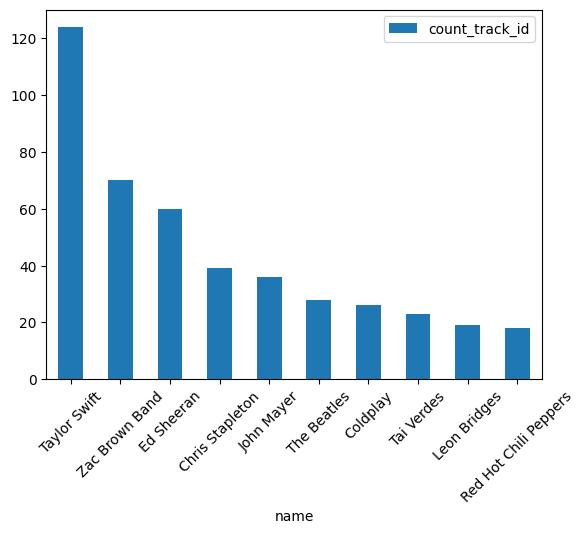

<Figure size 640x480 with 0 Axes>

In [36]:
id_str = 'id'
name_str = 'name'
count_track_id_str = f'count_{track_id_str}'

# Use the DataFrame linking tracks to artists to get the number of tracks liked per artist.
num_tracks_per_artist = track_artists_df.groupby([id_str, name_str])[track_id_str].count() \
                                        .to_frame().sort_values(track_id_str, ascending = False) \
                                        .reset_index().rename(columns = {track_id_str: count_track_id_str})

num_tracks_per_artist.head(10).plot(kind = 'bar', x = name_str, y = count_track_id_str, rot = 45)

plt.show()
plt.clf()

Let's see what else is in the data by looking at all artists who have more than 1 liked song.

In [37]:
display(num_tracks_per_artist[num_tracks_per_artist[count_track_id_str] >= 2][[name_str, count_track_id_str]])

,name,count_track_id
0,Taylor Swift,124
1,Zac Brown Band,70
2,Ed Sheeran,60
3,Chris Stapleton,39
4,John Mayer,36
5,The Beatles,28
6,Coldplay,26
7,Tai Verdes,23
8,Leon Bridges,19
9,Red Hot Chili Peppers,18


Remove unneeded columns from the data and display to ensure it looks as expected.

In [48]:
my_track_artists = num_tracks_per_artist[[id_str, name_str, count_track_id_str]]

display(my_track_artists.head())

,id,name,count_track_id
0,06HL4z0CvFAxyc27GXpf02,Taylor Swift,124
1,6yJCxee7QumYr820xdIsjo,Zac Brown Band,70
2,6eUKZXaKkcviH0Ku9w2n3V,Ed Sheeran,60
3,4YLtscXsxbVgi031ovDDdh,Chris Stapleton,39
4,0hEurMDQu99nJRq8pTxO14,John Mayer,36


### Timeline of When Tracked Are Liked <a name="timeline"></a>

Next up in our analysis, we ultimately a flat file to see how liked artists' track count has grown over time. One limitation of this analysis is that we do not know when tracks are potentially *unliked.* To do so, a pipeline could be developed to poll this endpoint and create snapshots, but that is out of scope for this application.

In this block, we do some setup. We calculate all YYYY-MM formatted dates for which the user liked songs, filling in dates where no songs were liked along the way. Then, we create a template DataFrame for our analysis with *all* dates for *all* artists.

In [39]:
# Variable setup
added_at_ym_str = added_at_str + '_ym'
added_at_ymd_str = added_at_ym_str + 'd'

# Pull in the added_at field for each track
track_artists_df_with_added_at = pd.merge(track_artists_df, my_tracks[[track_id_str, added_at_str]] \
                                         , on = track_id_str)

# Create fields for added_at formatted as YYYY-MM and YYYY-MM-DD
track_artists_df_with_added_at[added_at_ym_str] = track_artists_df_with_added_at[added_at_str].dt.strftime('%Y-%m')
track_artists_df_with_added_at[added_at_ymd_str] = track_artists_df_with_added_at[added_at_str].dt.date

# Create a DataFrame of all YYYY-MM dates between the minimum added_at and maximum added_at
added_at_date_range_pd_series = track_artists_df_with_added_at[added_at_ymd_str]

added_at_date_range_df = pd.date_range(start = added_at_date_range_pd_series.min() \
                                       , end = added_at_date_range_pd_series.max()) \
                             .strftime('%Y-%m').drop_duplicates() \
                             .to_frame().reset_index(drop = True).rename(columns = {0: added_at_ym_str})

# For each unique artist with tracks liked, create a DataFrame of all possible added_at YYYY-MM combinations
# with that artist's information, and bind the rows of all DataFrames together
unique_artists_df = track_artists_df_with_added_at[[id_str, name_str]].drop_duplicates().reset_index(drop = True)

unique_artists_all_dates_list = list()
    
for i, df_row in unique_artists_df.iterrows():
    tmp_unique_artist_base = unique_artists_df.iloc[[i]].reset_index(drop = True)
    
    tmp_unique_artist = pd.concat([added_at_date_range_df, tmp_unique_artist_base], axis = 1)
    
    for curr_col in tmp_unique_artist_base.columns:
        tmp_unique_artist[curr_col].fillna(df_row[curr_col], inplace = True)
    
    unique_artists_all_dates_list.append(tmp_unique_artist)

unique_artists_all_dates_df = pd.concat(unique_artists_all_dates_list).reset_index(drop = True)

Here, we essentially fill-in the template we just created with liked songs per YYYY-MM per artist.

In [40]:
# Calculate the number of liked songs per artist per YYYY-MM
artist_month_indexes = [id_str, name_str, added_at_ym_str]

num_tracks_per_artist_month = track_artists_df_with_added_at.groupby(artist_month_indexes)[track_id_str].count() \
                                        .to_frame().sort_values(added_at_ym_str) \
                                        .reset_index().rename(columns = {track_id_str: count_track_id_str})

# Outer merge with all possible liked song dates, and fill NAs with 0.
num_tracks_per_artist_month = pd.merge(num_tracks_per_artist_month \
                                       , unique_artists_all_dates_df \
                                       , on = artist_month_indexes \
                                       , how = 'outer' \
                                       , sort = True).fillna(0)

display(num_tracks_per_artist_month.head(100))

,id,name,added_at_ym,count_track_id
0,00tVTdpEhQQw1bqdu8RCx2,Blue Öyster Cult,2021-12,1.0
1,00tVTdpEhQQw1bqdu8RCx2,Blue Öyster Cult,2022-01,0.0
2,00tVTdpEhQQw1bqdu8RCx2,Blue Öyster Cult,2022-02,0.0
3,00tVTdpEhQQw1bqdu8RCx2,Blue Öyster Cult,2022-03,0.0
4,00tVTdpEhQQw1bqdu8RCx2,Blue Öyster Cult,2022-04,0.0
5,00tVTdpEhQQw1bqdu8RCx2,Blue Öyster Cult,2022-05,0.0
6,00tVTdpEhQQw1bqdu8RCx2,Blue Öyster Cult,2022-06,0.0
7,00tVTdpEhQQw1bqdu8RCx2,Blue Öyster Cult,2022-07,0.0
8,00tVTdpEhQQw1bqdu8RCx2,Blue Öyster Cult,2022-08,0.0
9,00tVTdpEhQQw1bqdu8RCx2,Blue Öyster Cult,2022-09,0.0


Now, it gets a little more interesting. We add a running sum to see growth over time.

In [41]:
# Create a column that calculates the running sum of liked songs by ascending date for each artist.
# Data was sorted in the previous code block
runningsum_str = 'runningsum'

num_tracks_per_artist_month[runningsum_str] = num_tracks_per_artist_month.groupby([id_str])[count_track_id_str].cumsum()

display(num_tracks_per_artist_month.head(200))

,id,name,added_at_ym,count_track_id,runningsum
0,00tVTdpEhQQw1bqdu8RCx2,Blue Öyster Cult,2021-12,1.0,1.0
1,00tVTdpEhQQw1bqdu8RCx2,Blue Öyster Cult,2022-01,0.0,1.0
2,00tVTdpEhQQw1bqdu8RCx2,Blue Öyster Cult,2022-02,0.0,1.0
3,00tVTdpEhQQw1bqdu8RCx2,Blue Öyster Cult,2022-03,0.0,1.0
4,00tVTdpEhQQw1bqdu8RCx2,Blue Öyster Cult,2022-04,0.0,1.0
5,00tVTdpEhQQw1bqdu8RCx2,Blue Öyster Cult,2022-05,0.0,1.0
6,00tVTdpEhQQw1bqdu8RCx2,Blue Öyster Cult,2022-06,0.0,1.0
7,00tVTdpEhQQw1bqdu8RCx2,Blue Öyster Cult,2022-07,0.0,1.0
8,00tVTdpEhQQw1bqdu8RCx2,Blue Öyster Cult,2022-08,0.0,1.0
9,00tVTdpEhQQw1bqdu8RCx2,Blue Öyster Cult,2022-09,0.0,1.0


For the grand finale, we pivot the data so the dates are our columns, using the running sum values for the pivot table.

In [49]:
# Pivot the data
num_tracks_per_artist_month_pivot = num_tracks_per_artist_month.pivot_table(values = runningsum_str \
                                                                           , index = [id_str, name_str] \
                                                                           , columns = added_at_ym_str \
                                                                           , fill_value = 0)

display(num_tracks_per_artist_month_pivot.head())

,added_at_ym,2021-12,2022-01,2022-02,2022-03,2022-04,2022-05,2022-06,2022-07,2022-08,2022-09,2022-10,2022-11,2022-12,2023-01,2023-02
id,name,,,,,,,,,,,,,,,
00tVTdpEhQQw1bqdu8RCx2,Blue Öyster Cult,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
01QTIT5P1pFP3QnnFSdsJf,Lupe Fiasco,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
01lz5VBfkMFDteSA9pKJuP,The Click Five,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
02seUFsFQP7TH4hLrTj77o,Nathaniel Rateliff & The Night Sweats,0,2,2,2,2,2,2,2,2,2,2,4,4,4,4
04RtvnUz0XrUbUZzOA8ZoW,Sugarcult,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


Create the final CSV file for upload into other applications (see the README).

In [43]:
# Write out the final file
num_tracks_per_artist_month_pivot.reset_index(inplace = True)

spotify_write_df_to_data_out_csv(num_tracks_per_artist_month_pivot, 'num_tracks_per_artist_month_pivot_output')

### Additional API Exploration <a name="additionalapiexploration"></a>

In this section, we preview other available data from the Spotify API.

#### Long Term Top Tracks <a name="longtermtoptracks"></a>

Identify what Spotify has determined to be the user's long term top tracks by hitting the `/me/top/tracks` endpoint.

In [50]:
my_long_term_top_tracks = spotify_get_all_results(access_token \
                                                 , f'{spotify_api_endpoint}me/top/tracks' \
                                                 , 'application/json' \
                                                 , query = {'time_range': 'long_term'})

display(my_long_term_top_tracks.head())

IntProgress(value=0, bar_style='success', description='Loading:', max=3, style=ProgressStyle(description_width…

,album,artists,available_markets,disc_number,duration_ms,explicit,external_ids,external_urls,href,id,is_local,name,popularity,preview_url,track_number,type,uri
0,"{'album_type': 'ALBUM', 'artists': [{'external...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AR, AT, AU, BE, BG, BH, BO, BR, CA, C...",1,240600,False,{'isrc': 'USSM11800493'},{'spotify': 'https://open.spotify.com/track/1O...,https://api.spotify.com/v1/tracks/1Omt5bfz1tZU...,1Omt5bfz1tZUCqd26HxbS0,False,Beyond,70,https://p.scdn.co/mp3-preview/7c5fe5091080cbc0...,4,track,spotify:track:1Omt5bfz1tZUCqd26HxbS0
1,"{'album_type': 'ALBUM', 'artists': [{'external...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AR, AT, AU, BE, BG, BH, BO, BR, CA, C...",1,613026,True,{'isrc': 'USUG12103690'},{'spotify': 'https://open.spotify.com/track/5e...,https://api.spotify.com/v1/tracks/5enxwA8aAbwZ...,5enxwA8aAbwZbf5qCHORXi,False,All Too Well (10 Minute Version) (Taylor's Ver...,79,https://p.scdn.co/mp3-preview/d84e1deddbb72a58...,30,track,spotify:track:5enxwA8aAbwZbf5qCHORXi
2,"{'album_type': 'ALBUM', 'artists': [{'external...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AR, AT, AU, BE, BG, BH, BO, BR, CA, C...",1,204852,True,{'isrc': 'USUG12205717'},{'spotify': 'https://open.spotify.com/track/5o...,https://api.spotify.com/v1/tracks/5oqDgw5VGBln...,5oqDgw5VGBln5dSIOPWyBq,False,Karma,73,https://p.scdn.co/mp3-preview/c6a91547c864534f...,11,track,spotify:track:5oqDgw5VGBln5dSIOPWyBq
3,"{'album_type': 'ALBUM', 'artists': [{'external...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AR, AT, AU, BE, BG, BH, BO, BR, CA, C...",1,294520,True,{'isrc': 'USUG12002848'},{'spotify': 'https://open.spotify.com/track/3I...,https://api.spotify.com/v1/tracks/3IhtE4fkytdr...,3IhtE4fkytdrtEfV34UzkD,False,betty,61,https://p.scdn.co/mp3-preview/176d07401eefcc4e...,14,track,spotify:track:3IhtE4fkytdrtEfV34UzkD
4,"{'album_type': 'ALBUM', 'artists': [{'external...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AR, AT, AU, BE, BG, BH, BO, BR, CA, C...",1,260361,False,{'isrc': 'USUG12207556'},{'spotify': 'https://open.spotify.com/track/0a...,https://api.spotify.com/v1/tracks/0aV5uARAknQg...,0aV5uARAknQgYhBaK944FP,False,"Would've, Could've, Should've",76,https://p.scdn.co/mp3-preview/6c8ca1734a9f8ae7...,19,track,spotify:track:0aV5uARAknQgYhBaK944FP


#### Followed Artists <a name="followedartists"></a>

In this section, we will download the user's followed artists in the Spotify application, and determine if any followed artists do not have any liked songs.

First, let's call the `/me/following` endpoint to get the user's followed artists, and then display the results.

In [51]:
my_followed_artists = spotify_get_all_results(access_token \
                                              , f'{spotify_api_endpoint}me/following' \
                                              , 'application/json' \
                                              , query = {'type': 'artist'} \
                                              , base_obj = 'artists')

display(my_followed_artists.head())

IntProgress(value=0, bar_style='success', description='Loading:', max=2, style=ProgressStyle(description_width…

,external_urls,followers,genres,href,id,images,name,popularity,type,uri
0,{'spotify': 'https://open.spotify.com/artist/0...,"{'href': None, 'total': 39792417}",[pop],https://api.spotify.com/v1/artists/04gDigrS5kc...,04gDigrS5kc9YWfZHwBETP,"[{'height': 640, 'url': 'https://i.scdn.co/ima...",Maroon 5,88,artist,spotify:artist:04gDigrS5kc9YWfZHwBETP
1,{'spotify': 'https://open.spotify.com/artist/0...,"{'href': None, 'total': 68914283}",[pop],https://api.spotify.com/v1/artists/06HL4z0CvFA...,06HL4z0CvFAxyc27GXpf02,"[{'height': 640, 'url': 'https://i.scdn.co/ima...",Taylor Swift,99,artist,spotify:artist:06HL4z0CvFAxyc27GXpf02
2,{'spotify': 'https://open.spotify.com/artist/0...,"{'href': None, 'total': 19262636}","[alternative rock, funk metal, funk rock, perm...",https://api.spotify.com/v1/artists/0L8ExT028jH...,0L8ExT028jH3ddEcZwqJJ5,"[{'height': 640, 'url': 'https://i.scdn.co/ima...",Red Hot Chili Peppers,85,artist,spotify:artist:0L8ExT028jH3ddEcZwqJJ5
3,{'spotify': 'https://open.spotify.com/artist/0...,"{'href': None, 'total': 46682644}","[dance pop, pop]",https://api.spotify.com/v1/artists/0du5cEVh5yT...,0du5cEVh5yTK9QJze8zA0C,"[{'height': 640, 'url': 'https://i.scdn.co/ima...",Bruno Mars,91,artist,spotify:artist:0du5cEVh5yTK9QJze8zA0C
4,{'spotify': 'https://open.spotify.com/artist/0...,"{'href': None, 'total': 5784240}","[neo mellow, singer-songwriter]",https://api.spotify.com/v1/artists/0hEurMDQu99...,0hEurMDQu99nJRq8pTxO14,"[{'height': 640, 'url': 'https://i.scdn.co/ima...",John Mayer,80,artist,spotify:artist:0hEurMDQu99nJRq8pTxO14


Next, let's use an inner join to narrow down all of the user's liked track artists to just the artists the user follows. In other words, we obtain a DataFrame showing all of the artists that are both followed AND have liked songs.

In [52]:
my_left = my_track_artists
my_right = my_followed_artists

my_followed_and_liked_artists_df = pd.merge(my_left \
                                            , my_right \
                                            , on = id_str \
                                            , how = 'inner' \
                                            , suffixes = ('', '_y'))[my_left.columns]

display(my_followed_and_liked_artists_df.head())
print(my_followed_and_liked_artists_df.shape)

,id,name,count_track_id
0,06HL4z0CvFAxyc27GXpf02,Taylor Swift,124
1,6yJCxee7QumYr820xdIsjo,Zac Brown Band,70
2,6eUKZXaKkcviH0Ku9w2n3V,Ed Sheeran,60
3,4YLtscXsxbVgi031ovDDdh,Chris Stapleton,39
4,0hEurMDQu99nJRq8pTxO14,John Mayer,36


(34, 3)


Next, we use Python's Set type to create unique groups of artist IDs. We obtain all unique artist IDs with liked songs, all unique artist IDs who are being followed, and all unique artist IDs who are being followed and have liked songs.

We can then use set operations to obtain the individual pieces of this Venn diagram and remove the overlaps. By doing so, we can determine if there are artists we **LIKE** but do not **FOLLOW**, or if there are artists we **FOLLOW** that we do not **LIKE.**

In [53]:
# Create Sets
my_track_artists_ids = set(my_left[id_str])
my_followed_artists_ids = set(my_right[id_str])
my_followed_and_liked_artists_ids = set(my_followed_and_liked_artists_df[id_str])

# Use Set operations
my_unfollowed_track_artists_ids = my_track_artists_ids - my_followed_and_liked_artists_ids
my_followed_and_nonliked_artists_ids = my_followed_artists_ids - my_followed_and_liked_artists_ids

# TODO handle when my_followed_and_nonliked_artists_ids is non-empty

# Inspect data
my_unfollowed_track_artists_df = my_left[my_left[id_str].isin(my_unfollowed_track_artists_ids)]

my_top_unfollowed_artists_indices = my_unfollowed_track_artists_df[count_track_id_str] > 2

my_top_unfollowed_artists_df = my_unfollowed_track_artists_df[my_top_unfollowed_artists_indices] \
                                    .reset_index(drop = True)

display(my_top_unfollowed_artists_df.head())
print(my_top_unfollowed_artists_df.shape)

,id,name,count_track_id
0,2kCO8LXN1usaOPL3iEE28I,Tai Verdes,23
1,6WY7D3jk8zTrHtmkqqo5GI,Maren Morris,16
2,4DZGvSv2oMkBUnPz67E6z6,David Nail,9
3,3UUJfRbrA2nTbcg4i0MOwu,Original Broadway Cast of Hamilton,9
4,4wQ3PyMz3WwJGI5uEqHUVR,Allman Brothers Band,9


(69, 3)
